In [23]:
import pandas as pd
import numpy as np
ruta = 'https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/worlddometer_covid_ue.csv?_sm_au_=iVVwgRnFF56ntMqT26q8vKHV6CTMc'
datos = pd.read_csv(ruta, sep = ';')
df = pd.DataFrame(datos)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Num                     49 non-null     int64  
 1   Country                 49 non-null     object 
 2   Total Cases             49 non-null     object 
 3   New Cases               17 non-null     object 
 4   Total Deaths            46 non-null     object 
 5   New Deaths              7 non-null      float64
 6   Total Recovered         45 non-null     object 
 7   Active Cases            45 non-null     object 
 8   Serious Critical        37 non-null     object 
 9   Total Cases per 1M pop  48 non-null     object 
 10  Deaths per 1M pop       45 non-null     object 
 11  Total Tests             47 non-null     object 
 12  Tests per 1M pop        47 non-null     object 
 13  Population              48 non-null     object 
dtypes: float64(1), int64(1), object(12)
memory u

In [24]:
df.rename(columns={'Population ': 'Population'}, inplace = True)

In [25]:
if df['Total Deaths'].dtype == object:
  df['Total Deaths'] = pd.to_numeric(df['Total Deaths'].str.replace(',',''), errors= 'ignore')
else:
  print("La variable ya se ha convertido a numérica")

if df['Total Cases'].dtype == object:
  df['Total Cases'] = pd.to_numeric(df['Total Cases'].str.replace(',',''), errors= 'ignore')
else:
  print("La variable ya se ha convertido a numérica")

if df['Total Recovered'].dtype == object:
  df['Total Recovered'] = pd.to_numeric(df['Total Recovered'].str.replace(',',''), errors= 'ignore')
else:
  print("La variable ya se ha convertido a numérica")

if df['Total Tests'].dtype == object:
  df['Total Tests'] = pd.to_numeric(df['Total Tests'].str.replace(',',''), errors= 'ignore')
else:
  print("La variable ya se ha convertido a numérica")

if df['Population'].dtype == object:
  df['Population'] = pd.to_numeric(df['Population'].str.replace(',',''), errors= 'ignore')
else:
  print("La variable ya se ha convertido a numérica")


In [26]:
paises_filtrados = ['Spain', 'Italy', 'UK', 'France', 'Germany', 'Ukraine']
df_filtrado = df[df['Country'].isin(paises_filtrados)].copy()
df_filtrado['prob_surv'] = 1-df_filtrado['Total Deaths']/df_filtrado['Total Cases']
df_filtrado[['Country','Total Cases','Total Deaths', 'Total Recovered','prob_surv']].sort_values('prob_surv')

,Country,Total Cases,Total Deaths,Total Recovered,prob_surv
5,Italy,266853,35473.0,208224.0,0.867069
3,UK,332752,41498.0,NaN,0.875289
4,France,272530,30602.0,86177.0,0.887711
2,Spain,455621,29011.0,NaN,0.936326
6,Germany,242825,9363.0,217484.0,0.961441
7,Ukraine,119074,2527.0,56734.0,0.978778


Para calcular la probabilidad de sobrevivir se utiliza Laplace y probabilidad complementaria, se calcula la probabilidad de fallecer por la enfermedad para calcular la probabilidad complementaria de la siguiente manera **P(Sobrevivir)=1-P(Fallecer)**
donde **P(Fallecer) = Cantidad Fallecimientos/Cantidad de Casos** el pais donde hay mayor proabilidad de sobrevivir es Ucrania con 97.87% comparado con el país que tiene menor probabilidad de sobrevivir que es Italia con 86.50%.

In [27]:
# Laplace: casos posibles entre totales - probabilidad de muerte o no muerte
df_filtrado['prob_mort'] =  df_filtrado['Total Deaths']/df_filtrado['Total Cases']
df_filtrado['prob_surv'] = 1- ( df_filtrado['prob_mort'])
# Laplace: casos posibles entre totales - probabilidad de cada pais
df_filtrado['Total_Country'] = df_filtrado['Total Cases'].sum()
df_filtrado['prob_pais'] = df_filtrado['Total Cases'] /df_filtrado['Total_Country']
df_bayes = df_filtrado[['Country','Total Cases','Total Deaths','prob_pais','prob_surv','prob_mort']].copy()
df_filtrado[['Country','Total Cases','Total Deaths','prob_pais','prob_surv','prob_mort']]

,Country,Total Cases,Total Deaths,prob_pais,prob_surv,prob_mort
2,Spain,455621,29011.0,0.269653,0.936326,0.063674
3,UK,332752,41498.0,0.196935,0.875289,0.124711
4,France,272530,30602.0,0.161293,0.887711,0.112289
5,Italy,266853,35473.0,0.157933,0.867069,0.132931
6,Germany,242825,9363.0,0.143713,0.961441,0.038559
7,Ukraine,119074,2527.0,0.070472,0.978778,0.021222


In [28]:
#Teorema de probabilidad total
prob_mort_total = (df_filtrado['prob_mort']*df_filtrado['prob_pais']).sum()
prob_surv = (1-prob_mort_total)*100
print ('Probabilidad de sobrevivir en cualquier país:', prob_surv.round(2) ,"%")
print ('Probabilidad de morir en cualquier país:', (prob_mort_total*100).round(2) ,"%")

Probabilidad de sobrevivir en cualquier país: 91.21 %
Probabilidad de morir en cualquier país: 8.79 %


Aplicando el Teorema de la Probabilidad Total se obtiene que, de los infectados con COVID-19 el 91.21% es capaz de sobrevivir en cualquier país de los 6 seleccionados, el 8.79% fallece.

In [29]:
#Teorema de Bayes
df_bayes_copy = df_bayes.copy()
df_bayes['prob_surv_pais'] = 1-(df_bayes['prob_mort']*df_bayes['prob_pais'])/prob_mort_total
df_bayes['prob_mort_pais'] = df_bayes['prob_mort']*df_bayes['prob_pais']/prob_mort_total
df_bayes.sort_values('prob_surv_pais')

,Country,Total Cases,Total Deaths,prob_pais,prob_surv,prob_mort,prob_surv_pais,prob_mort_pais
3,UK,332752,41498.0,0.196935,0.875289,0.124711,0.720503,0.279497
5,Italy,266853,35473.0,0.157933,0.867069,0.132931,0.761083,0.238917
4,France,272530,30602.0,0.161293,0.887711,0.112289,0.793890,0.206110
2,Spain,455621,29011.0,0.269653,0.936326,0.063674,0.804606,0.195394
6,Germany,242825,9363.0,0.143713,0.961441,0.038559,0.936938,0.063062
7,Ukraine,119074,2527.0,0.070472,0.978778,0.021222,0.982980,0.017020


Los paises con porcentajes de sobrevivencia más altos son Ucrania con 98.29% y Alemania con 93.69%, los países donde es peor contraer COVID por altas tasas de mortalidad son Reino unido e Italia con 72.05% y 76.11% de probabilidad de sobrevivencia respectivamente. La probabilidad de seleccionar una persona fallecida que haya sido residente en España es de 19.53% basado en el teorema de Bayes **P(Espana∣Fallecido)=P(Fallecido∣Espana)×P(Espana)/P(Fallecido)**, de igual manera se calcula la probabilidad para cada país utilizando el mismo teorema, a continuación la formula general **P(CualquierPaís∣Fallecido)=P(Fallecido∣CualquierPaís)×P(País)/P(Fallecido)**.

Otra forma alternativa de calcular la probabilidad de que al seleccionar a una persona fallecida sea de España o de otro país es utilizando Laplace **P(Fallecido en Cualquier País) = Fallecidos por País/Total Fallecidos** se obtiene el mismo resultado que aplicar Bayes.

In [30]:
df_muertes = df_filtrado[['Country','Total Deaths']].copy()
total_muertes = df_muertes['Total Deaths'].sum()
df_muertes['prob_muerte_pais'] = df_muertes['Total Deaths']/total_muertes
df_muertes.sort_values('prob_muerte_pais', ascending = False)

,Country,Total Deaths,prob_muerte_pais
3,UK,41498.0,0.279497
5,Italy,35473.0,0.238917
4,France,30602.0,0.206110
2,Spain,29011.0,0.195394
6,Germany,9363.0,0.063062
7,Ukraine,2527.0,0.017020


# **ARBOL DE DECISIÓN**

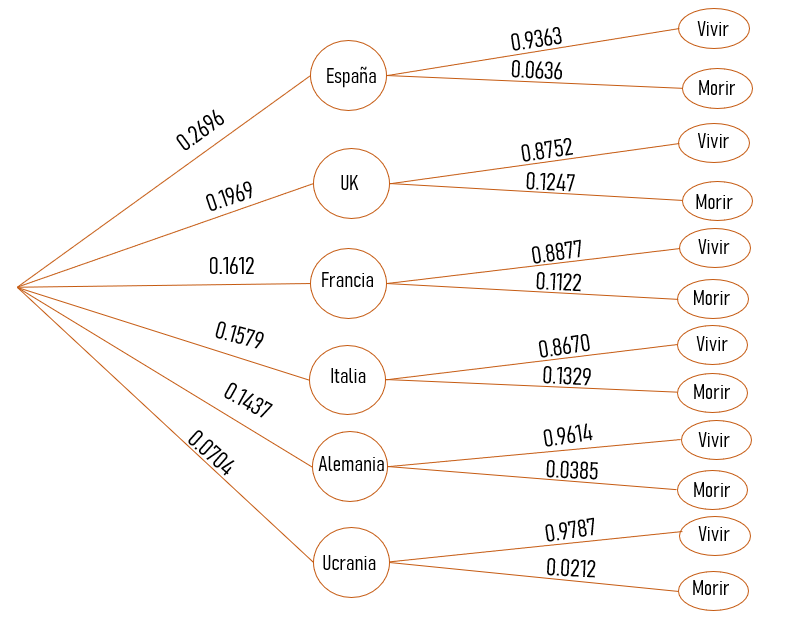

El árbol de decisión facilita mucho la aplicación del teorema de Bayes, se colocan las probabilidades en las ramas y cada nodo representa una decisión, es necesario tomar en cuenta que la suma de las probabilidades de cada nodo tiene que dar 1. El teorema de Bayes es útil para el cálculo de probabilidades de que ocurra un evento, dado otro evento.

Se obtiene un árbol que en sus ramas iniciales presenta la opción de contraer COVID en cualquiera de los 6 paises, luego por país existe la opción de morir o sobrevivir al Coronavirus, a manera de ejemplo, si se selecciona una persona fallecida aleatoriamente ¿cuál es la probabilidad de ser Español?, aplicando el teorema de Bayes esto sería P(España|Fallecido) = P​(Fallecido|España)*P(España)/P(Fallecido), se obtiene que la probabilidad es de 19.54%, esto puede comprobarse, aplicando Laplace de la siguiente manera P(Fallecido España) = Fallecidos España/Total Fallecidos dando el mismo resultado, una probabilidad de 19.54%.

